In [1]:
# to allow relative imports
import os
from sys_path_util import append_sys_path
append_sys_path()

from lib.experiments.utils.data_repo_api import DataRepoAPI

import pandas as pd
import matplotlib
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
import pickle
import datetime

from lib.configuration import DATA_REPO_URL_RAW

In [2]:
# https://censusreporter.org/profiles/05000US09009-new-haven-county-ct/
POPULATION = 854757
MAX_TIME = 200

covid = DataRepoAPI.get_csv('covid_by_county.csv')
covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,06/02/2020,1,Fairfield,"15,789","15,087",702,"1,673",134,"1,289",998,291.0
1,06/02/2020,2,Hartford,"10,593","9,914",679,"1,187",92,"1,259",958,301.0
2,06/02/2020,3,Litchfield,"1,404","1,338",66,775,5,133,113,20.0
3,06/02/2020,4,Middlesex,"1,161","1,104",57,714,16,152,118,34.0
4,06/02/2020,5,New Haven,"11,548","11,161",387,"1,347",150,990,843,147.0


In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2960 entries, 0 to 2959
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date updated        2960 non-null   object 
 1   County code         2960 non-null   int64  
 2   County              2960 non-null   object 
 3   Total cases         2960 non-null   object 
 4   Confirmed cases     2416 non-null   object 
 5   Probable cases      2416 non-null   object 
 6   Total case rate     2696 non-null   object 
 7   Hospitalized cases  2960 non-null   int64  
 8   Total deaths        2960 non-null   object 
 9   Confirmed deaths    2416 non-null   object 
 10  Probable deaths     2416 non-null   float64
dtypes: float64(1), int64(2), object(8)
memory usage: 254.5+ KB


In [4]:
# transform dates
covid['Date updated'] = pd.to_datetime(covid['Date updated'], format="%m/%d/%Y")
covid = covid.sort_values('Date updated').reset_index(drop=True)

col_transform = {
    'Total cases': 'float32',
    'Confirmed cases': 'float32',
    'Probable cases': 'float32',
    'Total case rate': 'float32',
    'Hospitalized cases': 'float32',
    'Total deaths': 'float32',
    'Confirmed deaths': 'float32',
    'Probable deaths': 'float32',
}

for c in col_transform:
    covid[c] = covid[c].apply(lambda x: x.replace(',', '') if type(x) == str else x, 1)

covid.replace('NaN', np.NaN, inplace=True)
    
# transform numbers
covid = covid.astype(col_transform)

# filter new haven county (code = 5)
new_haven_covid = covid[covid["County code"] == 5].copy()
new_haven_covid.reset_index(drop=True, inplace=True)

new_haven_covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,2020-03-24,5,New Haven,89.0,NaN,NaN,NaN,19.0,0.0,NaN,NaN
1,2020-03-25,5,New Haven,127.0,NaN,NaN,NaN,28.0,2.0,NaN,NaN
2,2020-03-26,5,New Haven,156.0,NaN,NaN,NaN,34.0,2.0,NaN,NaN
3,2020-03-27,5,New Haven,222.0,NaN,NaN,NaN,46.0,6.0,NaN,NaN
4,2020-03-28,5,New Haven,236.0,NaN,NaN,NaN,50.0,6.0,NaN,NaN


In [5]:
new_haven_covid = new_haven_covid[new_haven_covid['Date updated'] >= np.datetime64('2020-10-01')]
new_haven_covid.reset_index(drop=True, inplace=True)

In [6]:
start_date = new_haven_covid.loc[0, 'Date updated'].date()
new_haven_covid['Date updated'] = new_haven_covid['Date updated'].apply(lambda x: (x.date() - start_date).days)

In [7]:
new_haven_covid.head(40)

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,0,5,New Haven,14583.0,14044.0,539.0,1700.0,23.0,1115.0,958.0,157.0
1,3,5,New Haven,14715.0,14180.0,535.0,1716.0,28.0,1115.0,958.0,157.0
2,4,5,New Haven,14722.0,14184.0,538.0,1717.0,30.0,1115.0,958.0,157.0
3,5,5,New Haven,14749.0,14212.0,537.0,1720.0,32.0,1115.0,958.0,157.0
4,6,5,New Haven,14830.0,14294.0,536.0,1729.0,31.0,1117.0,960.0,157.0
5,7,5,New Haven,14877.0,14335.0,542.0,1735.0,31.0,1118.0,961.0,157.0
6,10,5,New Haven,15164.0,14634.0,530.0,1768.0,36.0,1119.0,962.0,157.0
7,11,5,New Haven,15223.0,14691.0,532.0,1775.0,44.0,1119.0,962.0,157.0
8,12,5,New Haven,15263.0,14726.0,537.0,1780.0,47.0,1119.0,962.0,157.0
9,13,5,New Haven,15310.0,14763.0,547.0,1785.0,46.0,1119.0,962.0,157.0


In [8]:
new_haven_covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,0,5,New Haven,14583.0,14044.0,539.0,1700.0,23.0,1115.0,958.0,157.0
1,3,5,New Haven,14715.0,14180.0,535.0,1716.0,28.0,1115.0,958.0,157.0
2,4,5,New Haven,14722.0,14184.0,538.0,1717.0,30.0,1115.0,958.0,157.0
3,5,5,New Haven,14749.0,14212.0,537.0,1720.0,32.0,1115.0,958.0,157.0
4,6,5,New Haven,14830.0,14294.0,536.0,1729.0,31.0,1117.0,960.0,157.0


In [9]:
first_val = new_haven_covid.loc[0, 'Total cases']
new_cases = new_haven_covid['Total cases'].diff().fillna(first_val).values.tolist()

new_haven_covid['New cases'] = [x / POPULATION for x in new_cases]

first200 = new_haven_covid.loc[new_haven_covid['Date updated'] <= MAX_TIME, :].copy()

<AxesSubplot:xlabel='Date updated'>

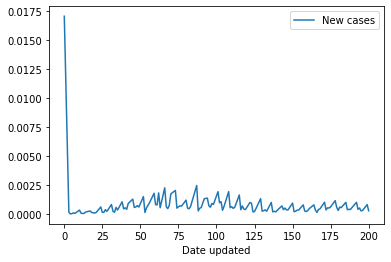

In [10]:
first200.plot(x='Date updated', y='New cases')

## Modelled

In [11]:
def get_df(name):
    url = DATA_REPO_URL_RAW + '/validation/' + name + '.pkl'

    with urlopen(url) as f:
        df = pickle.load(f)

    return df


def df_group_mean(df):
    grouped = df.groupby(['time', 'compartment']).mean()
    grouped.reset_index(inplace=True)
    return grouped


def get_wide(name, max_time):
    
    # get data frame
    df = get_df(name)
    
    # transform
    df = df[df.time <= max_time]
    grouped = df_group_mean(df)
    wide = grouped.pivot(index=['time'], columns=['compartment'], values='value')
    wide.reset_index(inplace=True)
    
    # calc new cases
    first_val = (-1) * (wide.loc[0, 'E'] + wide.loc[0, 'I'])
    new_cases = (wide['S'].diff().fillna(first_val) * (-1)).values.tolist()
    wide['New cases'] = new_cases
    
    # calc total cases
    wide['Total cases'] = wide['E'] + wide['I'] + wide['R']
    
    return wide
    

def make_nc_ts(name, max_time):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = wide['New cases'].values.tolist()
    return x, y


def make_tc_ts(name, max_time):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = [c for c in wide['Total cases'].values.tolist()]
    return x, y


def make_nc_smooth_ts(name, max_time, p):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = [c for c in wide['New cases'].rolling(p).mean().values.tolist()]
    return x, y

# ===========================

def new_haven_tc():
    x = first200['Date updated'].values.tolist()
    y = [c / POPULATION for c in first200['Total cases'].values.tolist()]
    return x, y


def new_haven_nc():
    x = first200['Date updated'].values.tolist()
    y = [c / POPULATION for c in first200['New cases'].values.tolist()]
    return x, y


def new_haven_nc_smooth(p):
    x = first200['Date updated'].values.tolist()
    y = [c / POPULATION for c in first200['New cases'].rolling(p).mean().values.tolist()]
    return x, y

## Comparison

In [15]:
_x1, _y1 = make_nc_smooth_ts('seir_mobility_pre_validation', MAX_TIME, 3)
_x2, _y2 = new_haven_tc()

In [17]:
_y2[0]

0.017060989263615274

<AxesSubplot:xlabel='time'>

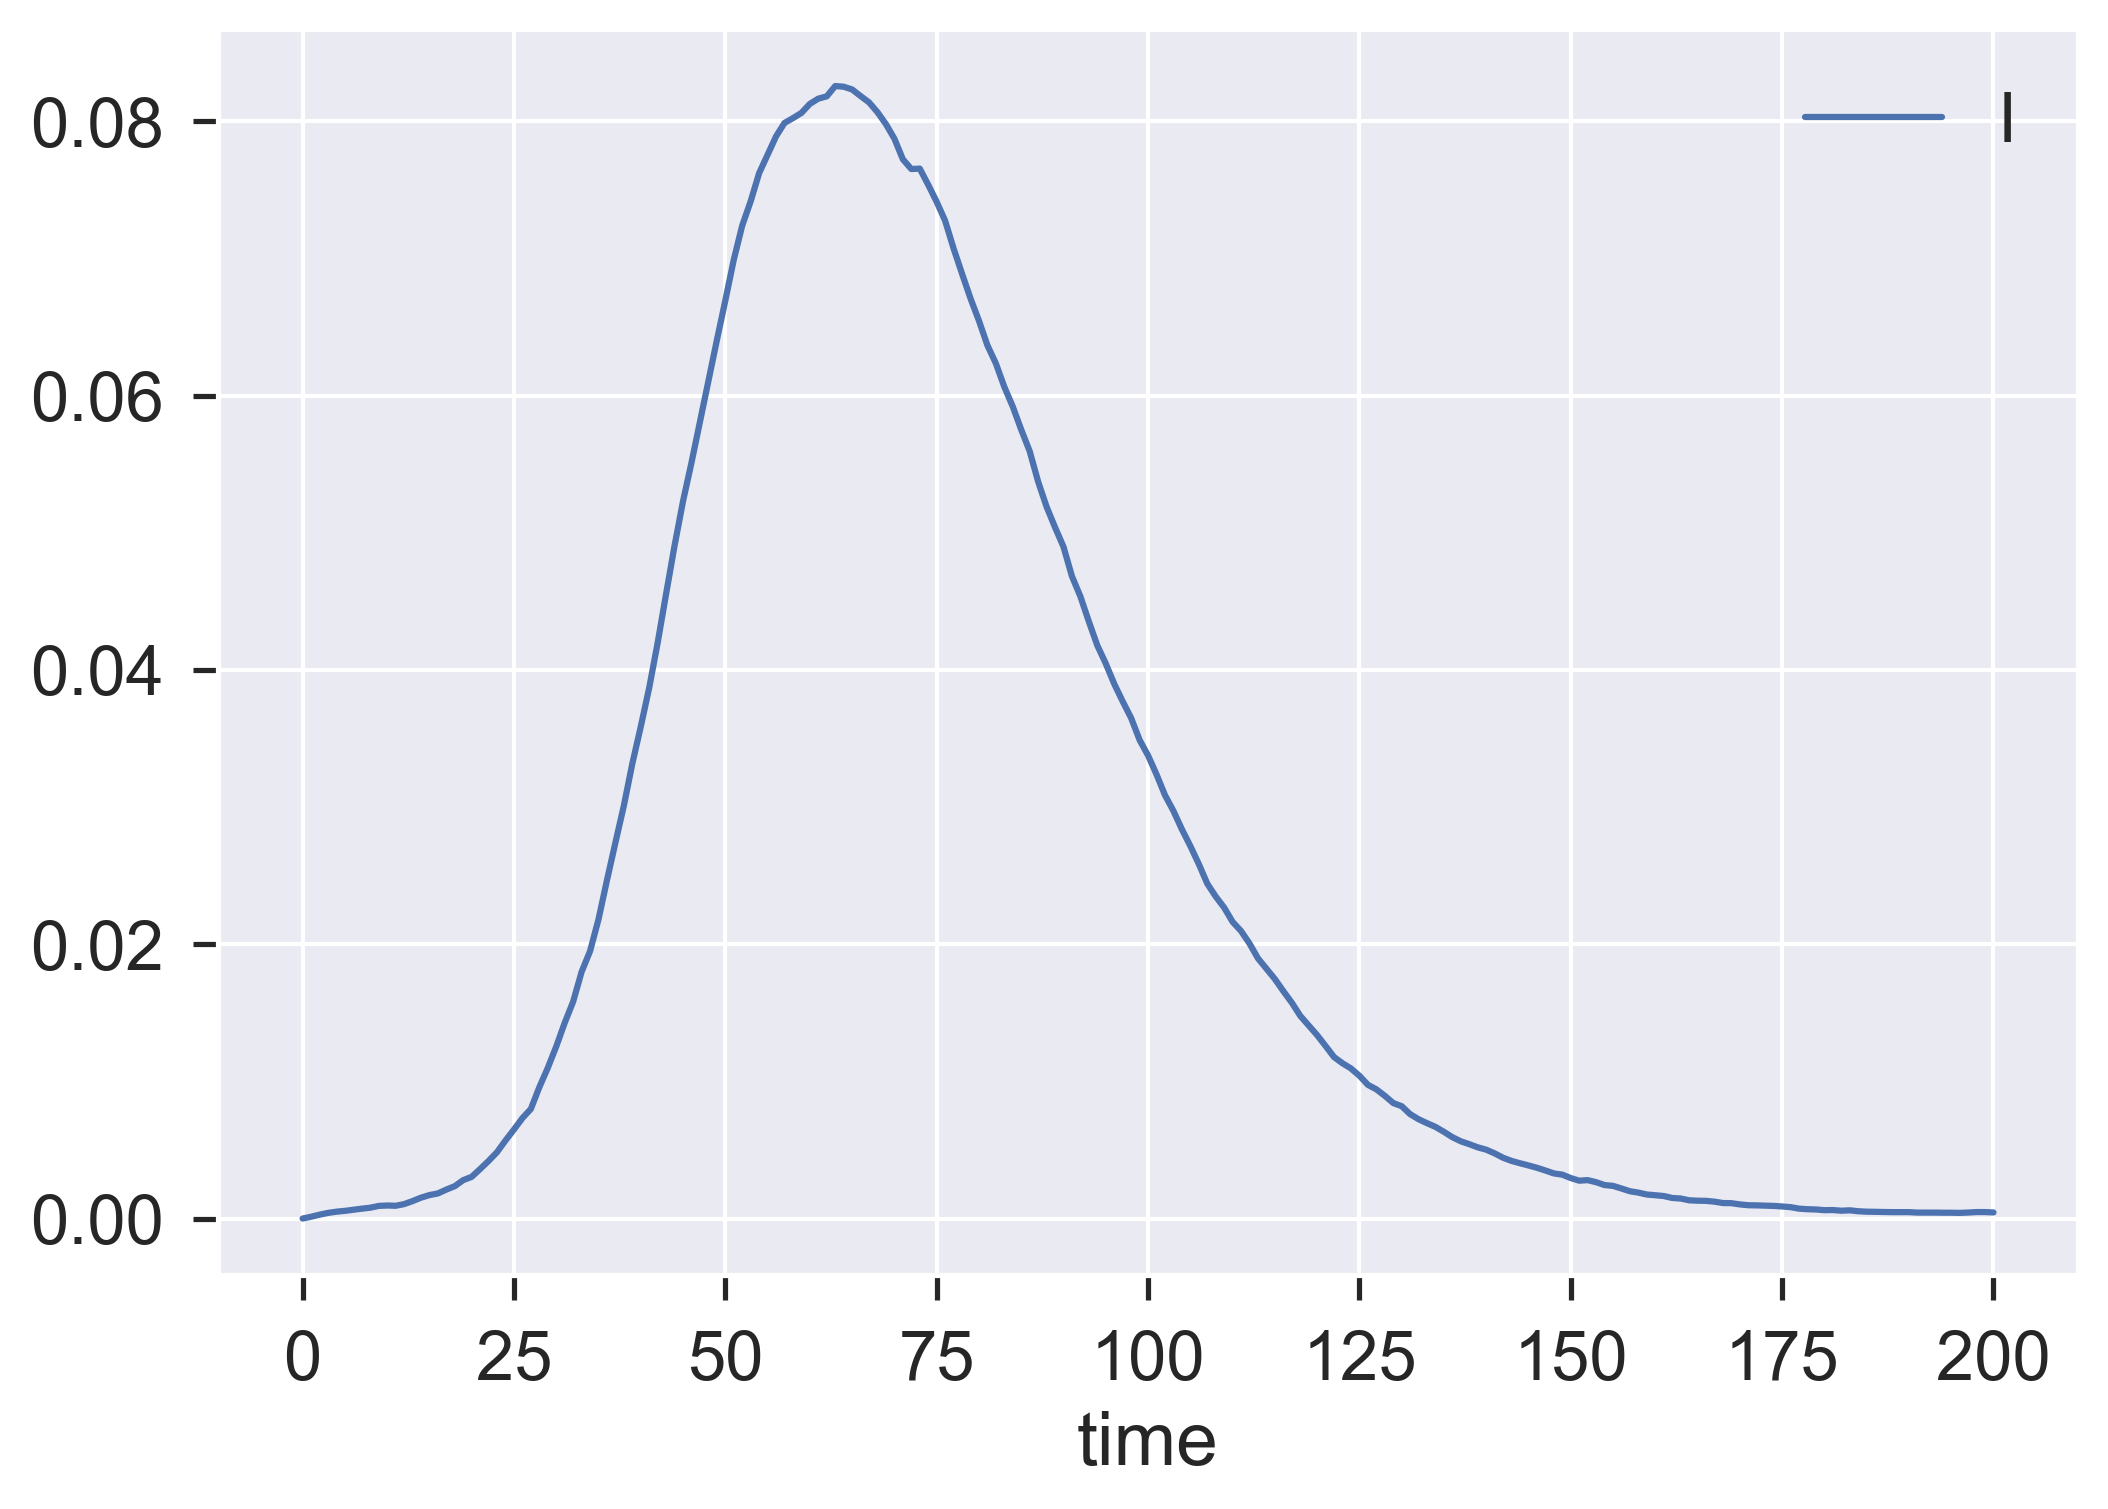

In [19]:
dd = get_wide('seir_mobility_pre_validation', MAX_TIME)
dd.plot(x='time', y='I')

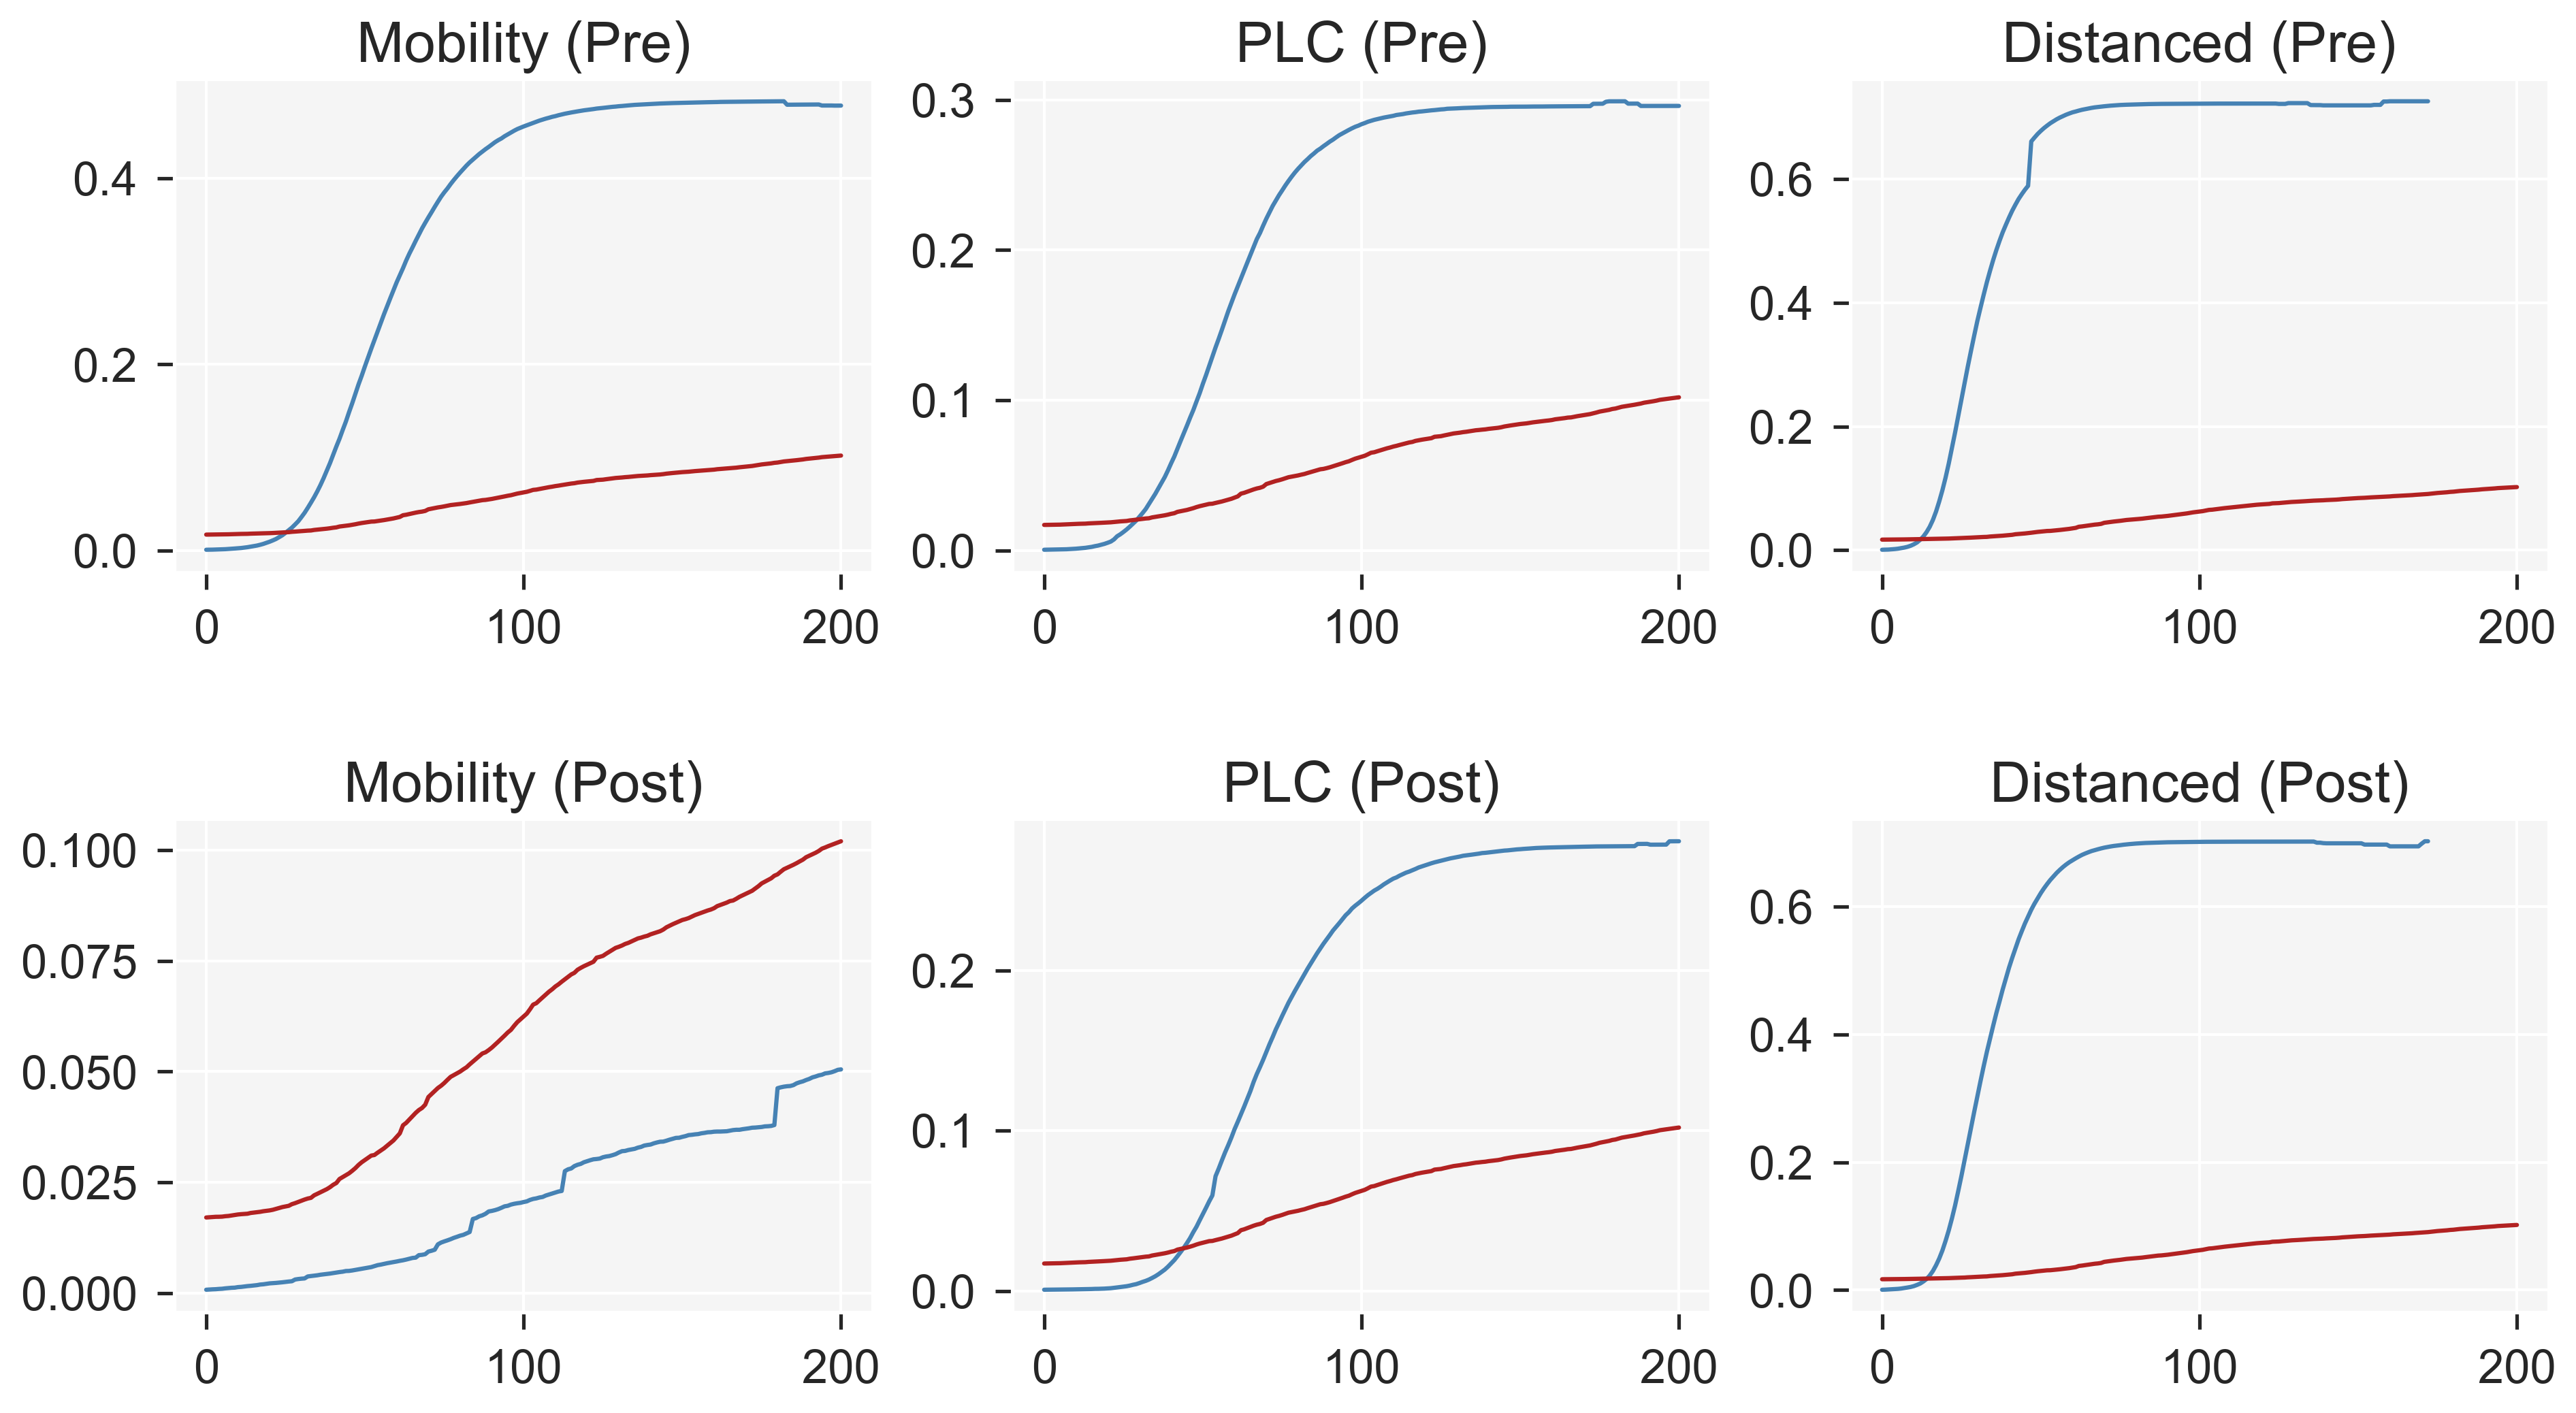

In [13]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (r1, r2) = plt.subplots(2, 3, figsize=(15, 8), facecolor='w', 
                             gridspec_kw={'width_ratios': [1, 1, 1]})

x, y = new_haven_tc()

data = [
    {'name': 'seir_mobility_pre_validation', 'title': 'Mobility (Pre)'},
    {'name': 'seir_plc_pre_validation', 'title': 'PLC (Pre)'},
    {'name': 'seir_distanced_pre_validation', 'title': 'Distanced (Pre)'},
    
    {'name': 'seir_mobility_post_validation', 'title': 'Mobility (Post)'},
    {'name': 'seir_plc_post_validation', 'title': 'PLC (Post)'},
    {'name': 'seir_distanced_post_validation', 'title': 'Distanced (Post)'},
]

for ax, d in zip([*r1, *r2], data):
    ax.plot(*make_tc_ts(d['name'], MAX_TIME), color='steelblue')
    ax.plot(x, y, color='firebrick')
    ax.set_facecolor('#F5F5F5')
    ax.set_title(d['title'], fontsize=20)

plt.subplots_adjust(hspace=0.5)
# plt.savefig(GRAPHICS + '/comparison-network-metrics.png', bbox_inches="tight")
plt.show()